In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2020-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

## Characterization Tutorial
This tutorial implements a characterization workload as described in the accompanying INRC paper. The tutorial relies on a configurable workload which takes 6 parameters:
 - The state of each neuron "INACTIVE"/"IDLE"/"SPIKING"
 - The number of neurons per core
 - The number of output axons per neuron
 - The distance (in tiles) between source and destination cores
 - The number of 64 bit Synaptic Memory words read by each arriving spike
 - The number of synapses contained in each 64 bit Synaptic Memory word

The neuron states are:
- **INACTIVE**: power gated and does not require updating 
- **IDLE**: updated on every timestep, but not generating any spikes 
- **SPIKING**: biased strongly enough to spike on every timestep

The figure below shows the flow. When a neuron spikes, it activates a configurable list of axons, where each axons specifies a core that a spike must be routed to. When the spike arrives at the receiving core, it triggers the retrieval of a list of Synaptic Memory words, each of which can contain multiple synapses. The synaptic updates are performed, but we turn off all neurons on the receiving core, so they never process their accumulated synaptic input.

![Processing pipeline](figures/processingPipeline.png)

The distance travelled by the spikes is controlled by changing where the target cores lie in the chip.
![Source and Sink Tiles](figures/source_sink_tiles.png)

The number of operations performed can be calculated based on the parameters in the figure below
![Computation](figures/computation.png)

Our helper function will calculate the number of ops explicitly and returns the counts as a dictionary used below.

In [2]:
from nxsdk_modules.characterization.src.characterization import *
import os
from nxsdk.logutils.nxlogging import set_verbosity, LoggingLevel
set_verbosity(LoggingLevel.WARNING)

External vLab:

In [3]:
#KAPOHO_BAY = os.environ.get('KAPOHOBAY')
#if KAPOHO_BAY:
    ## need to set boardName
    #numChips=2
#else:
    #boardName='ncl-ext-ghrd-01'
    #numChips=32

Internal vLab:

In [4]:
KAPOHO_BAY = os.environ.get('KAPOHOBAY')
if KAPOHO_BAY:
    print("Running on KB\n")
    boardName='ncl-nuc-01'
    numChips=2
else:
    print("Running on Nahuku\n")
    boardName='ncl-ghrd-01'
    numChips=32

Running on Nahuku



### Neuron Count and State
In the first test, the number of neurons per core is swept and the effect on timestep duration and energy is observed. The test is repeated for all 3 neuron states.

Running 1 INACTIVE Neurons per core
Running 2 INACTIVE Neurons per core
Running 4 INACTIVE Neurons per core
Running 8 INACTIVE Neurons per core
Running 16 INACTIVE Neurons per core
Running 32 INACTIVE Neurons per core
Running 64 INACTIVE Neurons per core
Running 128 INACTIVE Neurons per core
Running 256 INACTIVE Neurons per core
Running 512 INACTIVE Neurons per core
Running 1024 INACTIVE Neurons per core


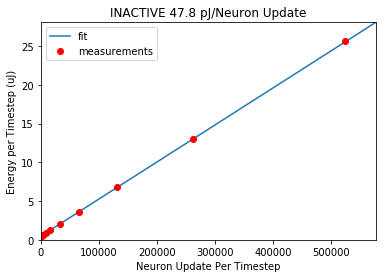

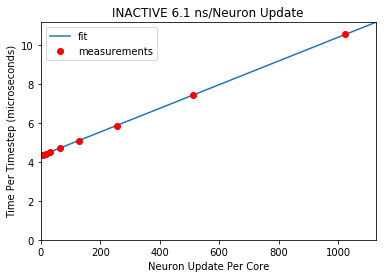

Running 1 IDLE Neurons per core
Running 2 IDLE Neurons per core.. 
Running 4 IDLE Neurons per core.. 
Running 8 IDLE Neurons per core.. 
Running 16 IDLE Neurons per core. 
Running 32 IDLE Neurons per core. 
Running 64 IDLE Neurons per core. 
Running 128 IDLE Neurons per core 
Running 256 IDLE Neurons per core 
Running 512 IDLE Neurons per core 
Running 1024 IDLE Neurons per core


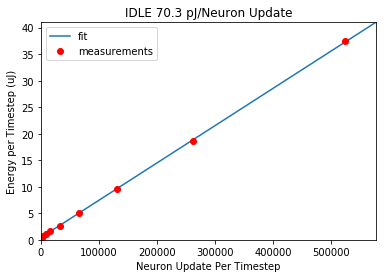

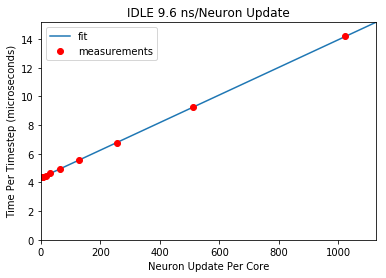

Running 1 SPIKING Neurons per core
Running 2 SPIKING Neurons per core
Running 4 SPIKING Neurons per core
Running 8 SPIKING Neurons per core
Running 16 SPIKING Neurons per core
Running 32 SPIKING Neurons per core
Running 64 SPIKING Neurons per core
Running 128 SPIKING Neurons per core
Running 256 SPIKING Neurons per core
Running 512 SPIKING Neurons per core
Running 1024 SPIKING Neurons per core


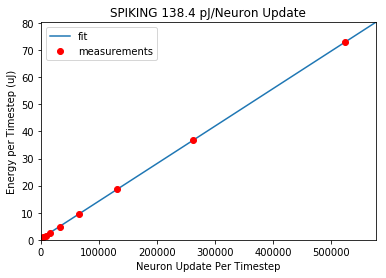

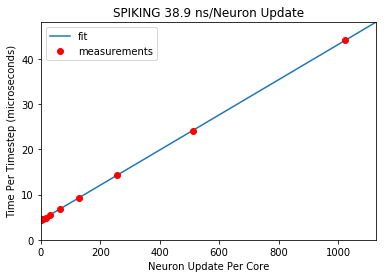

In [5]:
if KAPOHO_BAY:
    numNeuronsPerCore = np.array([128,192,256,384,512,768,1024])
    runTime = 1000000
else:
    numNeuronsPerCore = np.array([1,2,4,8,16,32,64,128,256,512,1024])
    runTime = 100000
neuronStates = ['INACTIVE', 'IDLE', 'SPIKING']
opName = 'Neuron Update'

for neuronStateTestValue in neuronStates:
    titleName = neuronStateTestValue
    timePerTimestep = np.zeros(numNeuronsPerCore.shape)
    neuroCoreDynamicEnergyPerTimestep = np.zeros(numNeuronsPerCore.shape)
    totalNeuronUpdatesPerTimestep = np.zeros(numNeuronsPerCore.shape)
    coreNeuronUpdatesPerTimestep = np.zeros(numNeuronsPerCore.shape)

    for ii, numNeuronsTestValue  in enumerate(numNeuronsPerCore):
        print("Running {} {} Neurons per core".format(numNeuronsTestValue, neuronStateTestValue))
        ops, powerStats = testWorkload(numNeuronsPerCore=numNeuronsTestValue,
                     neuronState=neuronStateTestValue,
                     outputAxonsPerNeuron=0,
                     spikeDistance=1,
                     synapseMemWordsPerSpike=0, 
                     synapsesPerWord=0,
                     runTime=runTime,
                     boardName=boardName,
                     numChips=numChips)

        neuroCoreDynamicEnergyPerTimestep[ii] = powerStats.power['core']['dynamic']*powerStats.timePerTimestep/1e3 #/1e3 to convert to uJ
        
        totalNeuronUpdatesPerTimestep[ii] = ops['total']['neuronUpdates']
        coreNeuronUpdatesPerTimestep[ii] = ops['perCore']['neuronUpdates']

        timePerTimestep[ii] = powerStats.timePerTimestep
    fitPowerPerOp(totalNeuronUpdatesPerTimestep, neuroCoreDynamicEnergyPerTimestep, opName, titleName=titleName)
    fitTimePerOp(coreNeuronUpdatesPerTimestep, timePerTimestep, opName, titleName=titleName)

Unsurprisingly, timestep duration and energy both show a clear linear relationship to the number of neurons per core.

The neurons state also affects timestep duration, with INACTIVE neurons being the fastest, IDLE neurons taking longer, and SPIKING NEURONS taking the longest.

### Spike Generation
The second test sweeps the number of axons per neuron (and therefore the number of output spikes per neuron).

Running 0 Axons per Neuron
Running 1 Axons per Neuron.. s... 
Running 2 Axons per Neuron.. s... 
Running 4 Axons per Neuron.. s... 
Running 8 Axons per Neuron.. s... 
Running 16 Axons per Neuron. s... 
Running 32 Axons per Neuron. s... 
Running 64 Axons per Neuron. s... 
Running 128 Axons per Neuron s... 
Running 256 Axons per Neuron s... 
Running 512 Axons per Neuron s... 
Running 1023 Axons per Neurons... 


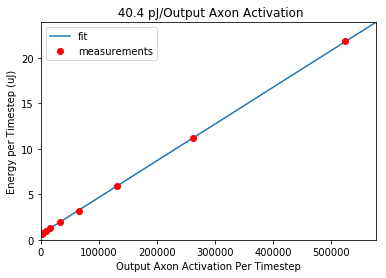

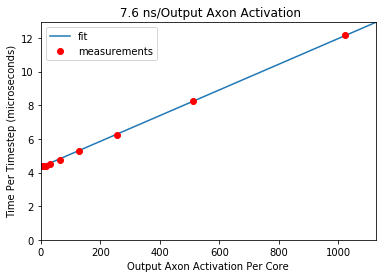

In [6]:
if KAPOHO_BAY:
    numAxonsPerNeuron = np.array([192,256,384,512,768,1023])
    runTime=100000
else:
    numAxonsPerNeuron = np.array([0,1,2,4,8,16,32,64,128,256,512,1023])
opName = 'Output Axon Activation'

timePerTimestep = np.zeros(numAxonsPerNeuron.shape)
neuroCoreDynamicEnergyPerTimestep = np.zeros(numAxonsPerNeuron.shape)
totalAxonActivationsPerTimestep = np.zeros(numAxonsPerNeuron.shape)
coreAxonActivationsPerTimestep = np.zeros(numAxonsPerNeuron.shape)

for ii, numAxonsTestValue  in enumerate(numAxonsPerNeuron):
    print("Running {} Axons per Neuron".format(numAxonsTestValue))
    ops, powerStats = testWorkload(numNeuronsPerCore=1,
                 neuronState='SPIKING',
                 outputAxonsPerNeuron=numAxonsTestValue,
                 spikeDistance=1,
                 synapseMemWordsPerSpike=0, 
                 synapsesPerWord=0,
                 runTime=runTime,
                 boardName=boardName,
                 numChips=numChips)

    neuroCoreDynamicEnergyPerTimestep[ii] = powerStats.power['core']['dynamic']*powerStats.timePerTimestep/1e3 #/1e3 to convert to uJ
    
    totalAxonActivationsPerTimestep[ii] = ops['total']['spikes']
    coreAxonActivationsPerTimestep[ii] = ops['perCore']['spikes']

    timePerTimestep[ii] = powerStats.timePerTimestep

fitPowerPerOp(totalAxonActivationsPerTimestep, neuroCoreDynamicEnergyPerTimestep, opName)
fitTimePerOp(coreAxonActivationsPerTimestep, timePerTimestep, opName)

Similar to before, timestep duration and energy both show a clear linear relationship to the number of spikes generated.

### Spike Distance
The third test sweeps the distance (measured in tiles) travelled by each spike and measures the power consumption.
Spike routing is very fast, so the timestep duration is defined by the much slower spike receiving at the receiving core, and therefore we will not see the effect of spike distance on timestep duration.

Running 1 tile-hops per spike
Running 2 tile-hops per spikes... 
Running 3 tile-hops per spikes... 
Running 4 tile-hops per spikes... 
Running 5 tile-hops per spikes... 
Running 6 tile-hops per spikes... 
Running 7 tile-hops per spikes... 


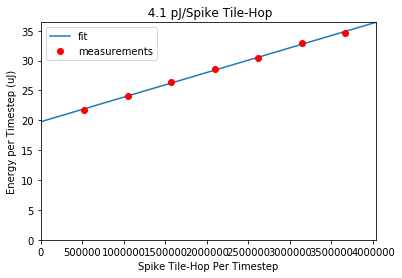

In [7]:
spikeDistances = np.array([1,2,3,4,5,6,7])
opName = 'Spike Tile-Hop'

timePerTimestep = np.zeros(spikeDistances.shape)
neuroCoreDynamicEnergyPerTimestep = np.zeros(spikeDistances.shape)
totalSpikeHopsPerTimestep = np.zeros(spikeDistances.shape)

for ii, spikeDistanceValue  in enumerate(spikeDistances):
    print("Running {} tile-hops per spike".format(spikeDistanceValue))
    ops, powerStats = testWorkload(numNeuronsPerCore=1,
                 neuronState='SPIKING',
                 outputAxonsPerNeuron=1023,
                 spikeDistance=spikeDistanceValue,
                 synapseMemWordsPerSpike=0, 
                 synapsesPerWord=0,
                 runTime=runTime,
                 boardName=boardName,
                 numChips=numChips)


    neuroCoreDynamicEnergyPerTimestep[ii] = powerStats.power['core']['dynamic']*powerStats.timePerTimestep/1e3 #/1e3 to convert to uJ
    
    totalSpikeHopsPerTimestep[ii] = ops['total']['spikeHops']

fitPowerPerOp(totalSpikeHopsPerTimestep, neuroCoreDynamicEnergyPerTimestep, opName)

Again we see a clear linear relationship between power and the distance travelled by each spike.

### Synaptic Word processing
This test sweeps the number of synaptic words indexed by each spike received.

Running 0 Synaptic Memory Words per spike
Running 1 Synaptic Memory Words per spike
Running 2 Synaptic Memory Words per spike
Running 4 Synaptic Memory Words per spike
Running 8 Synaptic Memory Words per spike
Running 16 Synaptic Memory Words per spike
Running 32 Synaptic Memory Words per spike
Running 64 Synaptic Memory Words per spike
Running 128 Synaptic Memory Words per spike
Running 255 Synaptic Memory Words per spike


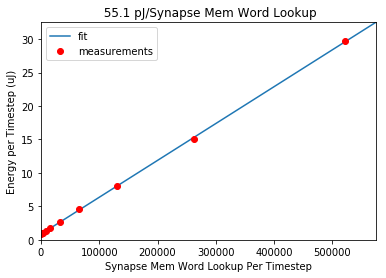

In [8]:
if KAPOHO_BAY:
    synMemWordsPerSpike = np.array([32,64,128,255])
else:
    synMemWordsPerSpike = np.array([0,1,2,4,8,16,32,64,128,255])
opName = 'Synapse Mem Word Lookup'

timePerTimestep = np.zeros(synMemWordsPerSpike.shape)
neuroCoreDynamicEnergyPerTimestep = np.zeros(synMemWordsPerSpike.shape)
totalSynMemWordsPerTimestep = np.zeros(synMemWordsPerSpike.shape)
coreSynMemWordsPerTimestep = np.zeros(synMemWordsPerSpike.shape)

for ii, synMemWordsValue  in enumerate(synMemWordsPerSpike):
    print("Running {} Synaptic Memory Words per spike".format(synMemWordsValue))
    ops, powerStats = testWorkload(numNeuronsPerCore=4,
                 neuronState='SPIKING',
                 outputAxonsPerNeuron=1,
                 spikeDistance=1,
                 synapseMemWordsPerSpike=synMemWordsValue, 
                 synapsesPerWord=0,
                 runTime=runTime,
                 boardName=boardName,
                 numChips=numChips)


    neuroCoreDynamicEnergyPerTimestep[ii] = powerStats.power['core']['dynamic']*powerStats.timePerTimestep/1e3 #/1e3 to convert to uJ
    
    totalSynMemWordsPerTimestep[ii] = ops['total']['synMemWords']
    
    timePerTimestep[ii] = powerStats.timePerTimestep

fitPowerPerOp(totalSynMemWordsPerTimestep, neuroCoreDynamicEnergyPerTimestep, opName)

The time and energy per synaptic memory word can be calculated as usual by fitting a line.

### Synaptic Operations
The final test sweeps the number of synapses per word to control the number of synaptic operations performed, while keeping all other operations constant

Running 4 Synapses per Synaptic Memory Word
Running 8 Synapses per Synaptic Memory Word
Running 16 Synapses per Synaptic Memory Word
Running 32 Synapses per Synaptic Memory Word


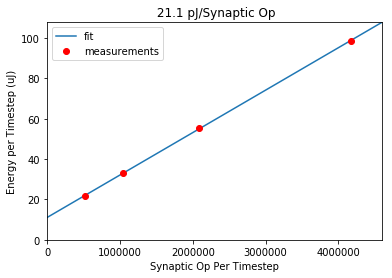

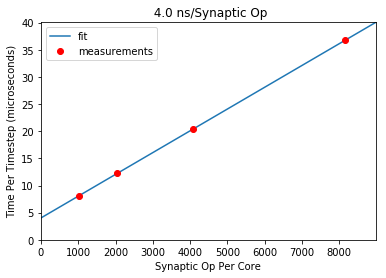

In [9]:
synapsesPerWord = np.array([4,8,16,32])
opName = 'Synaptic Op'

timePerTimestep = np.zeros(synapsesPerWord.shape)
neuroCoreDynamicEnergyPerTimestep = np.zeros(synapsesPerWord.shape)
totalSynopsPerTimestep = np.zeros(synapsesPerWord.shape)
coreSynopsPerTimestep = np.zeros(synapsesPerWord.shape)

for ii, synapsesPerWordValue  in enumerate(synapsesPerWord):
    print("Running {} Synapses per Synaptic Memory Word".format(synapsesPerWordValue))
    ops, powerStats = testWorkload(numNeuronsPerCore=1,
                 neuronState='SPIKING',
                 outputAxonsPerNeuron=1,
                 spikeDistance=1,
                 synapseMemWordsPerSpike=255, 
                 synapsesPerWord=synapsesPerWordValue,
                 runTime=runTime,
                 boardName=boardName,
                 numChips=numChips)

    neuroCoreDynamicEnergyPerTimestep[ii] = powerStats.power['core']['dynamic']*powerStats.timePerTimestep/1e3 #/1e3 to convert to uJ
    
    totalSynopsPerTimestep[ii] = ops['total']['synOps']
    coreSynopsPerTimestep[ii] = ops['perCore']['synOps']

    timePerTimestep[ii] = powerStats.timePerTimestep

fitPowerPerOp(totalSynopsPerTimestep, neuroCoreDynamicEnergyPerTimestep, opName)
fitTimePerOp(coreSynopsPerTimestep, timePerTimestep, opName)

Again, timestep duration and energy consumption both show a clear linear relationship to the number of synaptic operations being performed. 